# Trabalho 3 de Aprendizado de Máquina

Trabalho sobre Classificadores.

- **Aluna:** Bárbara Neves
- **Matrícula:** 388713

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importando os módulos das implementações feitas
from modules import models, utils

## Implementação

Foram criados 2 módulos (arquivos *``` .py ```*) para guardar as implementações solicitadas, além de outras funções criadas com o intuito de ajudar nas análises feitas neste trabalho. 

Os arquivos estão na pasta ``` modules/ ```, e a seguir estão os nomes e a descrição de cada um.
 
- **``` models ```:** contém as implementações da rede neural MLP para classificação e do método K-NN.
- **``` utils ```:** contém as implementações da função de acurácia, e os métodos ```plot_confusion_matrix``` e ```plot_boundaries```, feitas para o Trabalho 2 e a função ```k_fold```.

O import desses arquivos foi feito acima a partir do seguinte comando: ``` from modules import models, utils ```

## Conjunto de dados
### 1. Leitura do conjunto de dados: ``` data_trab3 ```

In [2]:
df = pd.DataFrame(columns=['X_0', 'X_1', 'y'])

with open('data_trab3/data1.txt', 'r') as f: 
    for line in f:
        try:
            line = float(line)
        except ValueError:
            pass
        split_line = line.split(',')
        df = df.append({
            'X_0': float(split_line[0]),
            'X_1': float(split_line[1]),
            'y': float(split_line[2])
        }, ignore_index=True)
        
df.head()

,X_0,X_1,y
0,34.623660,78.024693,0.0
1,30.286711,43.894998,0.0
2,35.847409,72.902198,0.0
3,60.182599,86.308552,1.0
4,79.032736,75.344376,1.0


### 2. X e y

A duas primeiras colunas são as características (X) e a última coluna é a variável alvo (y).

In [3]:
X = df.values[:, :-1]
y = df.values[:, -1]

X.shape, y.shape

((100, 2), (100,))

### 3. Normalização dos dados

In [4]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

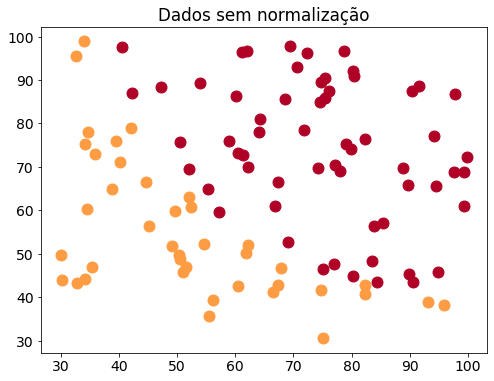

In [5]:
utils.plot_data(X, y, title='Dados sem normalização') 

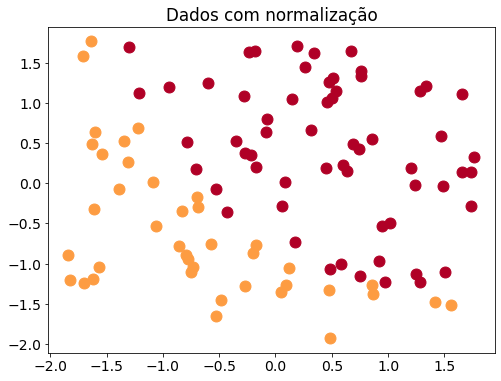

In [6]:
X = scaler.transform(X)

utils.plot_data(X, y, title='Dados com normalização')

## Relatório

### 1. Executar cada um dos métodos 

- K-NN, com k = 1, 2 e 3 
- MLP, com número de neurônios (*units*) = 2, 3 e 4

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((80, 2), (80,)), ((20, 2), (20,)))

In [8]:
KNN = models.KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train, y_train, batch=True)
y_pred = KNN.predict(X_test)

utils.accuracy_score(y_test, y_pred)

0.95

In [ ]:
#Fazer o k-fold 
#Fazer uma espécia de grid-search para rodar os modelos 
#Deixar a implementação da MLP p/ final 
#Analisar as matrizes de confusão (?)